In [2]:
import faiss 
import sys
import os
import math
import random
import heapq 
import time
import numpy as np
import pandas as pd
from PIL import Image
from io import StringIO,BytesIO 
import cv2
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pywt
from functools import reduce

In [3]:
#Baseline:  Wavelet transform.
def FeatureofWavelet(image_path):
    img = cv2.imread(image_path)
    if img is not None:
        img = cv2.resize(img, (128, 128))#resize image 1920x1942
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).astype(np.float32)  #turn  multi-channel to single-channel
        cA, (cH, cV, cD) = pywt.dwt2(data=img, wavelet='haar')#Single level Discrete Wavelet Transform.
    return cA.flatten()

#1. extracting features of trainset
root_dir = '/data/fjsdata/fundus/iSee/iSee_multi_dataset/' #the path of images
imgAttrs = [] # features with wf
imgInfos = [] # name and type
trainset = pd.read_csv("/data/fjsdata/fundus/iSee/iSee_multi_dataset/CBIR_iSee_train.csv" , sep=',')#load trainset
print('The length of test set is %d'%trainset.shape[0])
for iname, itype in np.array(trainset).tolist():
    if iname.endswith(".jpg"):
        try:
            image_dir = root_dir+'img_data_%s'%itype
            image_path = os.path.join(image_dir, iname)
            imgAttrs.append(FeatureofWavelet(image_path))#extracting feature
            imgInfos.append([iname, itype])
        except:
            print(iname+":"+str(image_path))
    sys.stdout.write('\r{} / {} '.format(len(imgInfos),trainset.shape[0]))
    sys.stdout.flush()
imgInfos = np.array(imgInfos)   

#2. buliding index of trainset
imgAttrs = np.array(imgAttrs).astype('float32') #must be float32
tstart = time.time()
cpu_index = faiss.IndexFlatL2(64*64) #cA is: 64*64
gpu_index = faiss.index_cpu_to_all_gpus(cpu_index) #make all gpu usable
gpu_index.add(imgAttrs) #add data to index
elapsed = time.time() - tstart    
print('Completed buliding index in %d seconds' % int(elapsed))

#3.extracting features of test set
testset = pd.read_csv("/data/fjsdata/fundus/iSee/iSee_multi_dataset/CBIR_iSee_test.csv" , sep=',')#load testset
print('The length of test set is %d'%testset.shape[0])
imgAttrs_test = []# features with wf
imgInfos_test = [] # name and type
for iname, itype in np.array(testset).tolist():
    image_dir = root_dir+'img_data_%s'%itype
    image_path = os.path.join(image_dir, iname)
    imgAttrs_test.append(FeatureofWavelet(image_path))#extracting feature
    imgInfos_test.append([iname, itype])
    sys.stdout.write('\r{} / {} '.format(len(imgInfos_test),testset.shape[0]))
    sys.stdout.flush()
imgInfos_test = np.array(imgInfos_test) 
imgAttrs_test = np.array(imgAttrs_test).astype('float32') #must be float32

#4.performance
for topk in [5,10,15,20]:
    MHR = [] #mean Hit ratio 
    MAP = [] #mean average precision
    MRR = [] #mean reciprocal rank
    for i in range(imgInfos_test.shape[0]):
        sname, stype = imgInfos_test[i]
        scores, neighbors = gpu_index.search(imgAttrs_test[i:i+1], k=topk)
        #perfromance
        pos_len = 0
        rank_len = 0
        mrr_flag = 0
        for j in neighbors.flatten():
            dname, dtype = imgInfos[j]
            rank_len=rank_len+1
            if stype==dtype:  #hit
                MHR.append(1)
                pos_len = pos_len +1
                MAP.append(pos_len/rank_len) 
                if mrr_flag==0: 
                    MRR.append(pos_len/rank_len)
                    mrr_flag =1
            else: 
                MHR.append(0)
                MAP.append(0)   
    print("MHR@{}={:.6f}, MAP@{}={:.6f}, MRR@{}={:.6f}".format(topk,np.mean(MHR),topk,np.mean(MAP), topk, np.mean(MRR)))

The length of test set is 9000
9000 / 9000 Completed buliding index in 5 seconds
The length of test set is 1000
1000 / 1000 MHR@5=0.659600, MAP@5=0.594710, MRR@5=0.879957
MHR@10=0.653500, MAP@10=0.568319, MRR@10=0.850281
MHR@15=0.652467, MAP@15=0.556226, MRR@15=0.820677
MHR@20=0.652650, MAP@20=0.550409, MRR@20=0.802711


/data/fjsdata/fundus/iSee/iSee_multi_dataset/img_data_AMD/494835.jpg
/data/fjsdata/fundus/iSee/iSee_multi_dataset/img_data_norm/912128.jpg
55
78


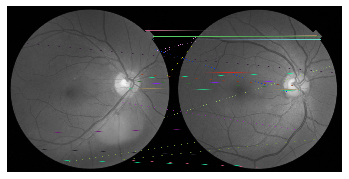

In [11]:
import cv2 
import matplotlib.pyplot as plt

sname, stype  = imgInfos_test[0]
image_dir = root_dir+'img_data_%s'%stype
img1_path = os.path.join(image_dir, sname)
print (img1_path)
s_cA = FeatureofWavelet(img1_path)
scores, neighbors = gpu_index.search(s_cA.reshape(1,64*64), k=5)
dname, dtype = imgInfos[neighbors.flatten()[0]]
image_dir = root_dir+'img_data_%s'%dtype
img2_path  = os.path.join(image_dir, dname)
print (img2_path)
# read images
img1 = cv2.imread(img1_path)  
img2 = cv2.imread(img2_path) 

img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

#sift
sift = cv2.xfeatures2d.SIFT_create()

keypoints_1, descriptors_1 = sift.detectAndCompute(img1,None)
keypoints_2, descriptors_2 = sift.detectAndCompute(img2,None)

print (len(keypoints_1))
print (len(keypoints_2))

#feature matching
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)#NORM_L2 is suitble for SIFT,SURF

matches = bf.match(descriptors_1,descriptors_2) 
matches = sorted(matches, key = lambda x:x.distance)

img3 = cv2.drawMatches(img1, keypoints_1, img2, keypoints_2, matches[:30], img2, flags=2)
plt.imshow(img3)
plt.axis('off')
plt.show()

In [5]:
#generate trainset and testset
data = [] # name and type
root_dir = '/data/fjsdata/fundus/iSee/iSee_multi_dataset/' #the path of images
for itype in ['AMD','DR','glaucoma','myopia','norm']:
    image_dir = root_dir+'img_data_%s'%itype
    for iname in sorted(os.listdir(image_dir)):
        data.append([iname, itype])    
data = np.array(data)
print('The length of data is %d'%data.shape[0])
testset = []
for itype in ['AMD','DR','glaucoma','myopia','norm']:
    if itype=='AMD': num=72
    elif itype=='DR': num=27
    elif itype=='glaucoma': num=45
    elif itype=='myopia': num=79
    else: num =777
    testset.extend(random.sample(data[data[:,1]==itype].tolist(),num))

#train
#trainset = list(set(imgInfos[:,0])-set(testset[:,0]))
trainset= []
for i in range(data.shape[0]):
    flag = 0
    for j in range(len(testset)):
        if (data[i][0]==testset[j][0]) and (data[i][1]==testset[j][1]):
            flag= 1
            break
    if flag == 0:
        trainset.append([data[i][0], data[i][1]])
        
trainset = np.array(trainset)
trainset = pd.DataFrame(trainset)
print('The length of train set is %d'%trainset.shape[0])
trainset.to_csv('/data/fjsdata/fundus/iSee/iSee_multi_dataset/CBIR_iSee_train.csv',index=0)#default sep is ','

#test
testset = np.array(testset)
testset = pd.DataFrame(testset)
print('The length of test set is %d'%testset.shape[0])
testset.to_csv('/data/fjsdata/fundus/iSee/iSee_multi_dataset/CBIR_iSee_test.csv',index=0)#default sep is ','

The length of data is 10000
The length of train set is 9000
The length of test set is 1000
